# Домашняя работа №1
## Часть первая
Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

In [1]:
import gym
import random
import warnings
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')

1.  Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии

Добавим вспомогательные методы для игры

In [2]:
def simple_strategy(env) -> bool:
  """
  Простая стратегия, 
  в завимости от суммы очков (19, 20, 21) 
  возвращает True или False
  """
  return (env._get_obs()[0] < 19)


def eps_greedy_strategy(env, eps, Q):
  """
  Реализация стратегии epsilon-greedy 
  С вероятностью eps выбираем рандом, 
  в противном случае - наиболее выгодное
  """
  state = env._get_obs()
  if random.uniform(0, 1) > eps:
      return Q[state].argmax()
  else:
      return random.randint(0, env.action_space.n - 1)


def play_one_game(strategy, env, *args, **kwargs): 
    """
    Функция описывающая процесс одной игры
    Принимает стратегию и среду и др
    Возвращает списки состояний, действий и наград игрока 
    """
    states, actions, rewards = [], [], [] 
    env.reset() 

    while True:
        states.append(env._get_obs())
        
        act = strategy(env, *args, **kwargs)
        actions.append(act)

        obs, reward, done, info = env.step(act)
        rewards.append(reward)

        if done:
            break

    env.close()
    return (states, actions, rewards)


def strategy_evaluation(strategy, env, num_games, *args, **kwargs):
  """
  Оценка предложенной стратегии
  для некоторого кол-ва игр num_games
  """
  cum_sum = 0
  reward_vals = []
  reward_sum = []
  for i in tqdm(range(num_games), disable=True):
    states, acts, rewards = play_one_game(strategy, env, *args, **kwargs)
    reward_vals.append(rewards[-1])

  return sum(reward_vals) / num_games

In [3]:
env = gym.make("Blackjack-v0")
total_reward = strategy_evaluation(simple_strategy, env, num_games=1000000)
print(total_reward) 

-0.201534


In [5]:
# Оценим методом Монте-Карло выигрыш от простой стратегии
def first_visit_monte_carlo(strategy, env, num_games=10000, gamma=0.5):
  """
  Метод Монте-карло. Учитываем только первое состояние
  """
  val = defaultdict(float)
  res = defaultdict(list)

  for i in tqdm(range(num_games)):
    states, acts, rewards = play_one_game(strategy ,env)
    g = 0
    for t in range(len(states) - 1, -1, -1):
      cur_reward = rewards[t]
      g = gamma * g + cur_reward
      state = states[t]
      if state not in states[:t]:
        res[state].append(g)
        val[state] = np.mean(res[state])
  return val

In [7]:
env = gym.make('Blackjack-v0')
result = first_visit_monte_carlo(simple_strategy, env, 500000)
print("\n", np.mean(list(result.values())))

100%|██████████| 500000/500000 [06:32<00:00, 1272.41it/s]


 -0.05578699032809926


In [8]:
def monte_carlo_control(env, num_games=10000, gamma=0.2):
  """
  First-visit Monte Carlo Control
  Строим наиболее выгодную стратегию
  """
  
  Q = defaultdict(lambda: np.zeros(env.action_space.n))
  res = defaultdict(list)

  decay = 0.99
  eps_min = 0.01
  eps_max = 1.00
  
  intermediate_results = []
  for i in tqdm(range(1, num_games + 1)):
    eps_max = max(eps_max * decay, eps_min)

    if (i % 10000) == 0:
      best_strategy = lambda env, Q: eps_greedy_strategy(env, 0, Q)
      intermediate_results.append(strategy_evaluation(best_strategy, env, num_games, Q))

    states, acts, rewards = play_one_game(eps_greedy_strategy, env, Q=Q, eps=eps_max)
    state_action = list(zip(states, acts))
    
    g = 0
    for t in range(len(states) - 1, -1, -1):
      cur_reward = rewards[t]
      g = gamma * g + cur_reward
      state = states[t]
      act = acts[t]

      if (state, act) not in state_action[:t]:
        res[(state, act)].append(g)
        Q[state][act] = np.mean(res[(state, act)])
  
  best_strategy = lambda env, Q: eps_greedy_strategy(env, 0, Q)
  return best_strategy, Q, intermediate_results

def plot_monte_carlo_for_gamma(x, y):
  fig, ax = plt.subplots(1, figsize=(15, 7))

  for i in range(len(x)):
      sns.lineplot(data=x[i], label=f"гамма: {round(y[i], 2)}")
      
  ax.set_ylabel('Премия', fontsize=15)
  ax.set_xlabel('Итерация', fontsize=15)
  plt.legend(loc="best")
  plt.title('Награды', fontsize=18);

100%|██████████| 200000/200000 [07:30<00:00, 444.05it/s] 


-0.05712


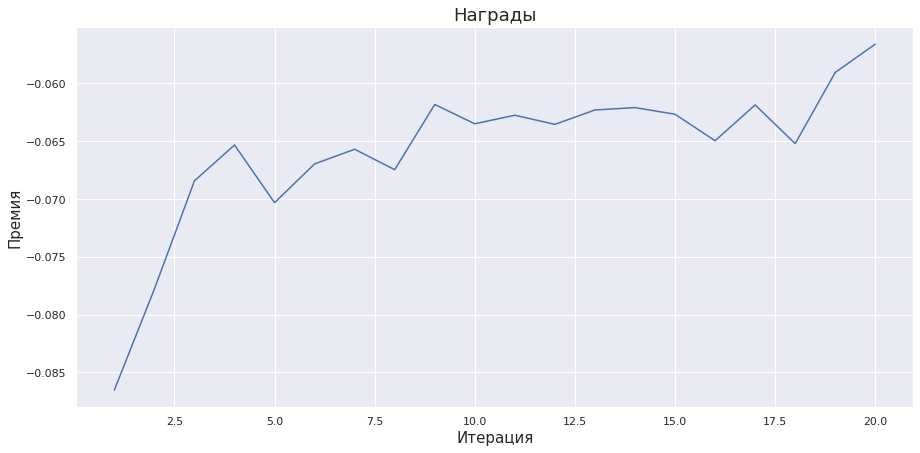

In [13]:
env = gym.make('Blackjack-v0')
best_strategy, Q, intermediate_results = monte_carlo_control(env, 200000)
total_reward = strategy_evaluation(best_strategy, env, 200000, Q)
print(total_reward)

fig, ax = plt.subplots(1, figsize=(15, 7))
sns.lineplot(range(1, 21),intermediate_results)
ax.set_ylabel('Премия', fontsize=15)
ax.set_xlabel('Итерация', fontsize=15)
plt.title('Награды', fontsize=18);

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Step for gamma = 0.0 start ---------- 


100%|██████████| 200000/200000 [07:51<00:00, 424.26it/s]


End --------------------------------- 
Step for gamma = 0.18 start ---------- 


100%|██████████| 200000/200000 [07:49<00:00, 426.02it/s] 


End --------------------------------- 
Step for gamma = 0.36 start ---------- 


100%|██████████| 200000/200000 [07:40<00:00, 434.26it/s] 


End --------------------------------- 
Step for gamma = 0.54 start ---------- 


100%|██████████| 200000/200000 [07:51<00:00, 423.98it/s]


End --------------------------------- 
Step for gamma = 0.72 start ---------- 


100%|██████████| 200000/200000 [07:54<00:00, 421.54it/s]


End --------------------------------- 
Step for gamma = 0.9 start ---------- 


100%|██████████| 200000/200000 [07:14<00:00, 460.70it/s]


End --------------------------------- 


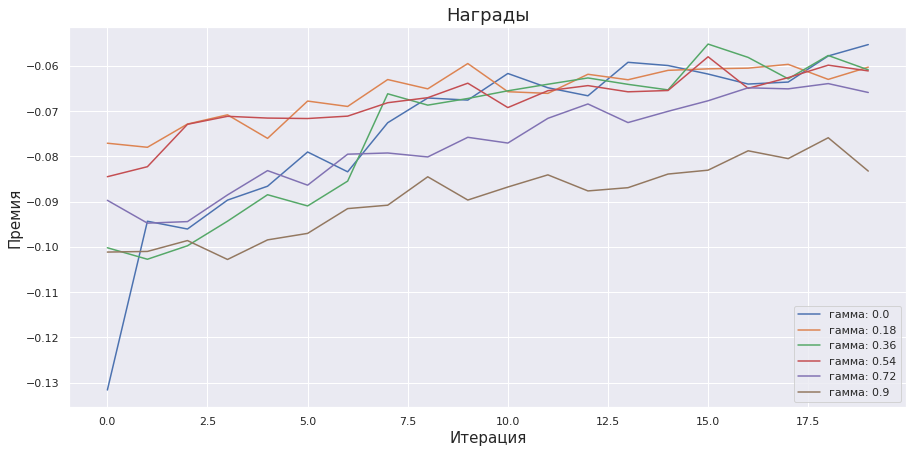

In [16]:
gammas = np.linspace(0.0, 0.9, 6)
env = gym.make('Blackjack-v0')

all_rewards = []
for gamma in gammas:
  print("Step for gamma =", gamma, "start ---------- ")
  best_strategy, Q, intermediate_results = monte_carlo_control(env, 200000, gamma)
  total_reward = strategy_evaluation(best_strategy, env, 200000, Q)
  all_rewards.append(intermediate_results)
  print("End --------------------------------- ")

plot_monte_carlo_for_gamma(all_rewards, gammas)

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
➢ double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [17]:
import blackjack_double as bd
env = bd.BlackjackDouble()
total_reward = strategy_evaluation(simple_strategy, env, num_games=200000)
print(total_reward)

-0.20184


5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Step for gamma = 0.0 start --------- 


100%|██████████| 200000/200000 [07:53<00:00, 422.40it/s]


End --------------------------------- 
Step for gamma = 0.18 start --------- 


100%|██████████| 200000/200000 [07:59<00:00, 416.82it/s]


End --------------------------------- 
Step for gamma = 0.36 start --------- 


100%|██████████| 200000/200000 [07:54<00:00, 421.41it/s]


End --------------------------------- 
Step for gamma = 0.54 start --------- 


100%|██████████| 200000/200000 [07:49<00:00, 426.29it/s]


End --------------------------------- 
Step for gamma = 0.72 start --------- 


100%|██████████| 200000/200000 [07:32<00:00, 441.97it/s]


End --------------------------------- 
Step for gamma = 0.9 start --------- 


100%|██████████| 200000/200000 [07:31<00:00, 443.23it/s]


End --------------------------------- 


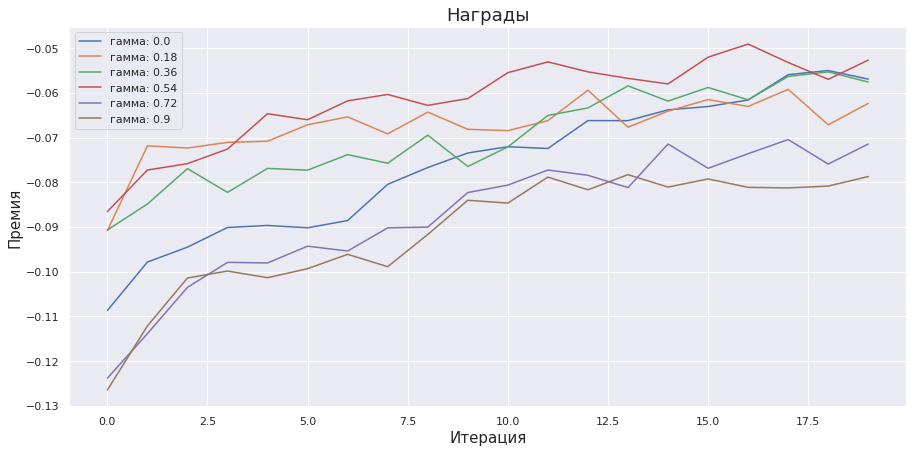

In [18]:
gammas = np.linspace(0.0, 0.9, 6)
env = bd.BlackjackDouble()

all_rewards = []
for gamma in gammas:
  print("Step for gamma =", gamma, "start --------- ")
  best_strategy, Q, intermediate_results = monte_carlo_control(env, 200000, gamma)
  total_reward = strategy_evaluation(best_strategy, env, 200000, Q)
  all_rewards.append(intermediate_results)
  print("End --------------------------------- ")

plot_monte_carlo_for_gamma(all_rewards, gammas)

## Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
Думаю, у вас уже возникла в голове эта картинка:
Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.
6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

In [19]:
import blackjack_counting as bc
env = bc.BlackjackCount()
total_reward = strategy_evaluation(simple_strategy, env, num_games=200000)
print(total_reward)

-0.19863


7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Step for gamma = 0.0 start --------- 


100%|██████████| 200000/200000 [04:42<00:00, 708.69it/s] 


End --------------------------------- 
Step for gamma = 0.18 start --------- 


100%|██████████| 200000/200000 [04:44<00:00, 703.12it/s]


End --------------------------------- 
Step for gamma = 0.36 start --------- 


100%|██████████| 200000/200000 [04:46<00:00, 698.28it/s]


End --------------------------------- 
Step for gamma = 0.54 start --------- 


100%|██████████| 200000/200000 [04:45<00:00, 700.34it/s] 


End --------------------------------- 
Step for gamma = 0.72 start --------- 


100%|██████████| 200000/200000 [04:36<00:00, 724.24it/s] 


End --------------------------------- 
Step for gamma = 0.9 start --------- 


100%|██████████| 200000/200000 [04:40<00:00, 713.44it/s] 


End --------------------------------- 


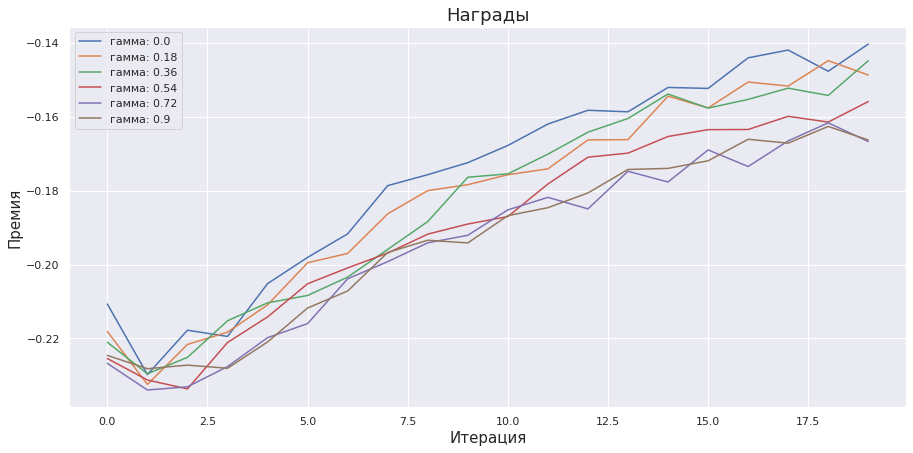

In [20]:
gammas = np.linspace(0.0, 0.9, 6)
env = bc.BlackjackCount()

all_rewards = []
for gamma in gammas:
  print("Step for gamma =", gamma, "start --------- ")
  best_strategy, Q, intermediate_results = monte_carlo_control(env, 200000, gamma)
  total_reward = strategy_evaluation(best_strategy, env, 200000, Q)
  all_rewards.append(intermediate_results)
  print("End --------------------------------- ")

plot_monte_carlo_for_gamma(all_rewards, gammas)

Выйти в ноль - что-то нереалистичное O_O